In [1]:
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import numpy as np
import os

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def show_results(_model, _hist):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.lineplot(x=range(len(_hist["accuracy"])), y=_hist["accuracy"], label="accuracy", ax=ax)
    sns.lineplot(x=range(len(_hist["accuracy"])), y=_hist["val_accuracy"], label="val accuracy", ax=ax)
    sns.lineplot(x=range(len(_hist["accuracy"])), y=_hist["loss"], label="loss", ax=ax)
    sns.lineplot(x=range(len(_hist["accuracy"])), y=_hist["val_loss"], label="val loss", ax=ax)

    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)

    report = classification_report(y_true, y_pred)
    print(report)

    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)


def save(name):
    with open(f"data/{name}.pickle", "wb") as handle:
        pickle.dump(hist, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(name, pck=False):
    with open(f"data/{name}.pickle", "rb") as handle:
        return pickle.load(handle)

In [3]:
wd = os.path.sep.join([os.getcwd(), "data"])
train_path = os.path.sep.join([wd, "train"])
test_path = os.path.sep.join([wd, "test"])
symblink_path = os.path.sep.join([wd, "symblink"])

input from multiple directories with keras https://stackoverflow.com/questions/60787620/combine-two-data-generator-to-train-a-cnn

## Declaration of the image generators used to train models without having to load images in cache

In [4]:
img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=.15)

training_gen_original = img_datagen.flow_from_directory(train_path, target_size=(51,51), subset="training", batch_size=32)
training_gen_augmented = img_datagen.flow_from_directory(symblink_path, target_size=(51,51), subset="training", batch_size=32, follow_links=True)


validation_gen_original = img_datagen.flow_from_directory(train_path, target_size=(51,51), subset="validation", batch_size=32)
validation_gen_augmented = img_datagen.flow_from_directory(symblink_path, target_size=(51,51), subset="validation", batch_size=32, follow_links=True)


test_gen = img_datagen.flow_from_directory(test_path, target_size=(51,51), batch_size=1)

Found 141722 images belonging to 2 classes.
Found 226722 images belonging to 2 classes.
Found 25008 images belonging to 2 classes.
Found 40008 images belonging to 2 classes.
Found 110794 images belonging to 2 classes.


In [5]:
epochs = 50
batch_size = 32
optimizer = Adam(learning_rate=0.0001)
callback = lambda x: [EarlyStopping(monitor='val_loss', patience=2, mode="min"), ModelCheckpoint(filepath=f"{wd}/{x}_weights.h5", monitor='val_loss', save_weights_only=True, save_best_only=True)]

# original
totalTrain_original = 141722 # total number of images in the train set
totalVal_original = 25008    # total number of images in the validation set

# original + augmented
totalTrain_augmented = 226722 # total number of images in the train set
totalVal_augmented = 40008    # total number of images in the validation set

## CNN - Declaration of the model

In [6]:
model = Sequential()
model.add(SeparableConv2D(32, (3, 3), activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(32, (3, 3), activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Model with unbalanced classes (without data augmentation)
### Perform classes weight to prioritize sample that are fewer (classe 1)

In [7]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(training_gen_original.classes), y=training_gen_original.classes)
train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 0.6984751259228593, 1: 1.7596036850338954}

In [8]:
hist = model.fit(x=training_gen_original, validation_data=validation_gen_original, callbacks=callback("CNN_unbalanced"), epochs=epochs, batch_size=batch_size, steps_per_epoch=totalTrain_original // batch_size, validation_steps=totalVal_original // batch_size).history

Epoch 1/50
4428/4428 [==============================] - 294s 66ms/step - loss: 0.5154 - accuracy: 0.8018 - val_loss: 0.4369 - val_accuracy: 0.8025
Epoch 2/50
4428/4428 [==============================] - 202s 46ms/step - loss: 0.3996 - accuracy: 0.8364 - val_loss: 0.4012 - val_accuracy: 0.8169
Epoch 3/50
4428/4428 [==============================] - 204s 46ms/step - loss: 0.3747 - accuracy: 0.8435 - val_loss: 0.4065 - val_accuracy: 0.8165
Epoch 4/50
4428/4428 [==============================] - 201s 45ms/step - loss: 0.3620 - accuracy: 0.8482 - val_loss: 0.3886 - val_accuracy: 0.8243
Epoch 5/50
4428/4428 [==============================] - 208s 47ms/step - loss: 0.3530 - accuracy: 0.8509 - val_loss: 0.4135 - val_accuracy: 0.8121
Epoch 6/50
4428/4428 [==============================] - 206s 46ms/step - loss: 0.3454 - accuracy: 0.8533 - val_loss: 0.3758 - val_accuracy: 0.8292
Epoch 7/50
4428/4428 [==============================] - 208s 47ms/step - loss: 0.3419 - accuracy: 0.8548 - val_loss: 0

              precision    recall  f1-score   support

           0       0.72      0.78      0.75     79385
           1       0.29      0.22      0.25     31409

    accuracy                           0.62    110794
   macro avg       0.50      0.50      0.50    110794
weighted avg       0.59      0.62      0.61    110794



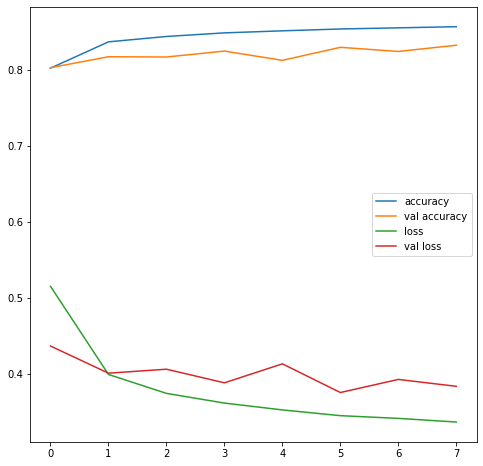

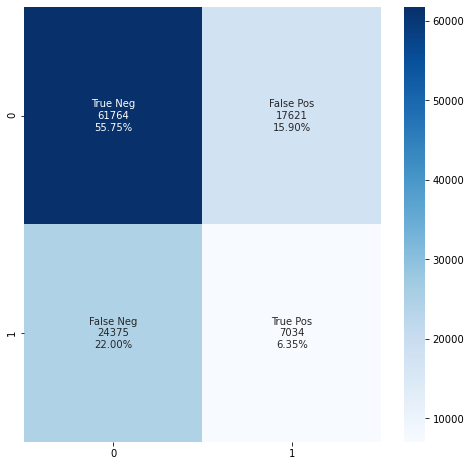

In [9]:
model.load_weights("data/CNN_unbalanced_weights.h5")
save("history_unbalanced")
hist = load("history_unbalanced")
show_results(_model=model, _hist=hist)

### Batch size comparaison :
128 -> Val accuracy: .76 - 5min
64 -> Val accuracy: .82 - 15min
32 -> Val accuracy: .84 - 20min

## Model with balanced classes data augmentation

In [10]:
hist = model.fit(x=training_gen_augmented, validation_data=training_gen_augmented, callbacks=callback("CNN_balanced"), epochs=epochs, batch_size=batch_size, steps_per_epoch=totalTrain_augmented // batch_size, validation_steps=totalVal_augmented // batch_size).history

Epoch 1/50
7085/7085 [==============================] - 337s 48ms/step - loss: 0.2921 - accuracy: 0.8915 - val_loss: 0.2259 - val_accuracy: 0.9061
Epoch 2/50
7085/7085 [==============================] - 326s 46ms/step - loss: 0.2474 - accuracy: 0.8983 - val_loss: 0.2315 - val_accuracy: 0.9060
Epoch 3/50
7085/7085 [==============================] - 335s 47ms/step - loss: 0.2398 - accuracy: 0.9014 - val_loss: 0.2169 - val_accuracy: 0.9079
Epoch 4/50
7085/7085 [==============================] - 335s 47ms/step - loss: 0.2354 - accuracy: 0.9024 - val_loss: 0.2135 - val_accuracy: 0.9085
Epoch 5/50
7085/7085 [==============================] - 348s 49ms/step - loss: 0.2314 - accuracy: 0.9037 - val_loss: 0.2167 - val_accuracy: 0.9077
Epoch 6/50
7085/7085 [==============================] - 359s 51ms/step - loss: 0.2296 - accuracy: 0.9049 - val_loss: 0.2118 - val_accuracy: 0.9113
Epoch 7/50
7085/7085 [==============================] - 357s 50ms/step - loss: 0.2264 - accuracy: 0.9057 - val_loss: 0

Found 110794 images belonging to 2 classes.
              precision    recall  f1-score   support

           0       0.72      0.73      0.72     79385
           1       0.29      0.28      0.28     31409

    accuracy                           0.60    110794
   macro avg       0.50      0.50      0.50    110794
weighted avg       0.59      0.60      0.60    110794



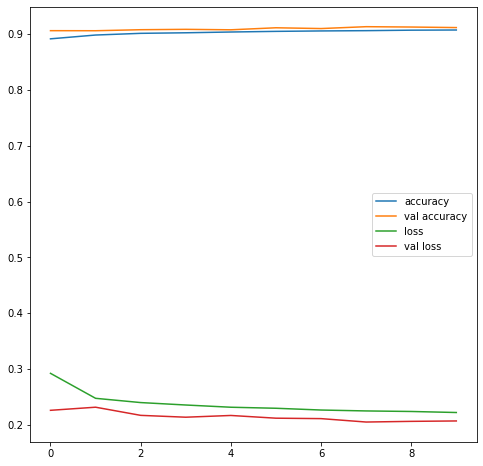

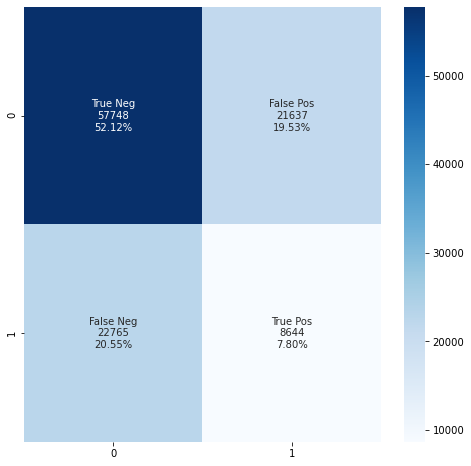

In [11]:
model.load_weights("data/CNN_balanced_weights.h5")
save("history_balanced")
hist = load("history_balanced")
test_gen = img_datagen.flow_from_directory(test_path, target_size=(51,51), batch_size=1) # reset test flow
show_results(_model=model, _hist=hist)